data collection, refer to
- LSTMs in Keras- VirtualCurrency- Simple.ipynb

for source code,refer to 
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import seaborn as sns
import numpy as np
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
# alpha dataset, for bitbank
#dataset = read_csv('update_20190301_bitbank_f.csv', header=0, index_col=0)
# dataset from poloniex.com
dataset = read_csv('bitcoin201901to201905.csv', header=0, index_col=0)
values = dataset.values

dataset.head()

Using TensorFlow backend.


,Close,High,Low,Open,Volume
Timestamp,,,,,
1546300800,3697.730000,3700.0000,3691.000002,3696.202300,7095.559257
1546301700,3695.179141,3697.9878,3687.024301,3694.186356,2142.803493
1546302600,3703.000000,3707.7001,3697.897800,3697.957800,15972.302727
1546303500,3703.000000,3711.4200,3703.000000,3703.000044,5796.233350
1546304400,3691.603671,3709.9000,3691.603671,3697.977800,1297.983519


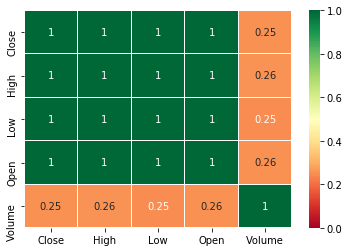

In [2]:
sns.heatmap(dataset.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [3]:

# ensure all data is float
values = values.astype('float32')
print('before scale')
test1 =  series_to_supervised(values, 1, 1)
print(test1.head())
print(test1.shape)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)


before scale
     var1(t-1)    var2(t-1)    var3(t-1)    var4(t-1)     var5(t-1)  \
1  3697.729980  3700.000000  3691.000000  3696.202393   7095.559082   
2  3695.179199  3697.987793  3687.024414  3694.186279   2142.803467   
3  3703.000000  3707.700195  3697.897705  3697.957764  15972.302734   
4  3703.000000  3711.419922  3703.000000  3703.000000   5796.233398   
5  3691.603760  3709.899902  3691.603760  3697.977783   1297.983521   

       var1(t)      var2(t)      var3(t)      var4(t)       var5(t)  
1  3695.179199  3697.987793  3687.024414  3694.186279   2142.803467  
2  3703.000000  3707.700195  3697.897705  3697.957764  15972.302734  
3  3703.000000  3711.419922  3703.000000  3703.000000   5796.233398  
4  3691.603760  3709.899902  3691.603760  3697.977783   1297.983521  
5  3701.000000  3701.000000  3694.721191  3694.721191   1487.381592  
(13747, 10)


In [4]:
print(values.shape)
print(reframed.shape)
reframed.head()

(13748, 5)
(13747, 10)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.068520,0.065730,0.068572,0.066926,0.003056,0.068006,0.065325,0.067764,0.066518,0.000923
2,0.068006,0.065325,0.067764,0.066518,0.000923,0.069584,0.067280,0.069974,0.067282,0.006880
3,0.069584,0.067280,0.069974,0.067282,0.006880,0.069584,0.068029,0.071012,0.068302,0.002497
4,0.069584,0.068029,0.071012,0.068302,0.002497,0.067284,0.067723,0.068695,0.067286,0.000559
5,0.067284,0.067723,0.068695,0.067286,0.000559,0.069181,0.065932,0.069328,0.066627,0.000641


In [5]:
import math

# drop columns we don't want to predict
# 只留下 close 列
# for alpha's bitbank
#reframed.drop(reframed.columns[[6, 7, 8, 10, 11]], axis=1, inplace=True)
# for dataset from poloniex.com
reframed.drop(reframed.columns[[6, 7, 8, 9]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
print(values.shape)

n_train_rate = 0.9
n_train = values.shape[0] * n_train_rate
n_train = math.floor(n_train)
print(n_train)

train = values[:n_train, :]
test = values[n_train:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.068520   0.065730   0.068572   0.066926   0.003056  0.068006
2   0.068006   0.065325   0.067764   0.066518   0.000923  0.069584
3   0.069584   0.067280   0.069974   0.067282   0.006880  0.069584
4   0.069584   0.068029   0.071012   0.068302   0.002497  0.067284
5   0.067284   0.067723   0.068695   0.067286   0.000559  0.069181
(13747, 6)
12372
(12372, 1, 5) (12372,) (1375, 1, 5) (1375,)


In [6]:
'''
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False)
'''

import talos
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_grid = {
#    'clf__neurons_input':   [20, 25, 30, 35],
    'batch_size': [40,60,80], 
    'epochs': [10, 25, 50]
#    'clf__optimizer': ['Adam', 'Adadelta']
}

def create_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

model=KerasRegressor(build_fn=create_model, epochs=10, verbose=1)

p = {
    'epochs': [10, 25, 50],
    'batch_size': [16, 32, 50]
}

grid = GridSearchCV(estimator=model, param_grid=p, scoring='neg_mean_squared_error',
                               verbose=3,n_jobs=1)

    # fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)

grid.fit(train_X, train_y, validation_data=(test_X, test_y), verbose=2, shuffle=False)



/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


NO INTERNET CONNECTION: Reporting plots will not work.
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] batch_size=16, epochs=10 ........................................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 8248 samples, validate on 1375 samples
Epoch 1/10
 - 1s - loss: 0.0087 - val_loss: 0.0401
Epoch 2/10
 - 1s - loss: 0.0078 - val_loss: 0.0234
Epoch 3/10
 - 1s - loss: 0.0045 - val_loss: 0.0092
Epoch 4/10
 - 1s - loss: 0.0030 - val_loss: 0.0063
Epoch 5/10
 - 1s - loss: 0.0023 - val_loss: 0.0132
Epoch 6/10
 - 1s - loss: 0.0019 - val_loss: 0.0122
Epoch 7/10
 - 1s - loss: 0.0019 - val_loss: 0.0097
Epoch 8/10
 - 1s - loss: 0.0020 - val_loss: 0.0123
Epoch 9/10
 - 1s - loss: 0.0019 - val_loss: 0.0078
Epoch 10/10
 - 1s - loss: 0.0020 - val_loss: 0.0069
8248/8248 [==============================] - 0s 24us/step
[CV]  batch_size=16, epochs=10, score=-4.878718755207956e-05, total=   9.0s
[

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


Train on 8248 samples, validate on 1375 samples
Epoch 1/10
 - 1s - loss: 0.0119 - val_loss: 0.0454
Epoch 2/10
 - 1s - loss: 0.0076 - val_loss: 0.0294
Epoch 3/10
 - 1s - loss: 0.0046 - val_loss: 0.0172
Epoch 4/10
 - 1s - loss: 0.0033 - val_loss: 0.0098
Epoch 5/10
 - 1s - loss: 0.0026 - val_loss: 0.0067
Epoch 6/10
 - 1s - loss: 0.0019 - val_loss: 0.0066
Epoch 7/10
 - 1s - loss: 0.0018 - val_loss: 0.0089
Epoch 8/10
 - 1s - loss: 0.0018 - val_loss: 0.0072
Epoch 9/10
 - 1s - loss: 0.0018 - val_loss: 0.0087
Epoch 10/10
 - 1s - loss: 0.0018 - val_loss: 0.0138
8248/8248 [==============================] - 0s 26us/step
[CV]  batch_size=16, epochs=10, score=-1.0643992936820723e-05, total=   8.5s
[CV] batch_size=16, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.9s remaining:    0.0s


Train on 8248 samples, validate on 1375 samples
Epoch 1/10
 - 1s - loss: 0.0107 - val_loss: 0.3088
Epoch 2/10
 - 1s - loss: 0.0055 - val_loss: 0.2116
Epoch 3/10
 - 1s - loss: 0.0041 - val_loss: 0.1259
Epoch 4/10
 - 1s - loss: 0.0031 - val_loss: 0.0645
Epoch 5/10
 - 1s - loss: 0.0023 - val_loss: 0.0364
Epoch 6/10
 - 1s - loss: 0.0021 - val_loss: 0.0070
Epoch 7/10
 - 1s - loss: 0.0019 - val_loss: 0.0105
Epoch 8/10
 - 1s - loss: 0.0018 - val_loss: 0.0067
Epoch 9/10
 - 1s - loss: 0.0017 - val_loss: 0.0091
Epoch 10/10
 - 1s - loss: 0.0018 - val_loss: 0.0131
8248/8248 [==============================] - 0s 27us/step
[CV]  batch_size=16, epochs=10, score=-6.345774454530329e-05, total=   8.8s
[CV] batch_size=16, epochs=25 ........................................
Train on 8248 samples, validate on 1375 samples
Epoch 1/25
 - 2s - loss: 0.0082 - val_loss: 0.0473
Epoch 2/25
 - 1s - loss: 0.0079 - val_loss: 0.0298
Epoch 3/25
 - 1s - loss: 0.0051 - val_loss: 0.0140
Epoch 4/25
 - 1s - loss: 0.0032 - v

Epoch 50/50
 - 1s - loss: 0.0018 - val_loss: 0.0064
8248/8248 [==============================] - 0s 26us/step
[CV]  batch_size=16, epochs=50, score=-0.00020814577874261886, total=  42.7s
[CV] batch_size=16, epochs=50 ........................................
Train on 8248 samples, validate on 1375 samples
Epoch 1/50
 - 2s - loss: 0.0109 - val_loss: 0.0537
Epoch 2/50
 - 1s - loss: 0.0074 - val_loss: 0.0410
Epoch 3/50
 - 1s - loss: 0.0047 - val_loss: 0.0287
Epoch 4/50
 - 1s - loss: 0.0035 - val_loss: 0.0233
Epoch 5/50
 - 1s - loss: 0.0028 - val_loss: 0.0195
Epoch 6/50
 - 1s - loss: 0.0024 - val_loss: 0.0189
Epoch 7/50
 - 1s - loss: 0.0022 - val_loss: 0.0182
Epoch 8/50
 - 1s - loss: 0.0020 - val_loss: 0.0174
Epoch 9/50
 - 1s - loss: 0.0018 - val_loss: 0.0131
Epoch 10/50
 - 1s - loss: 0.0019 - val_loss: 0.0087
Epoch 11/50
 - 1s - loss: 0.0018 - val_loss: 0.0099
Epoch 12/50
 - 1s - loss: 0.0017 - val_loss: 0.0072
Epoch 13/50
 - 1s - loss: 0.0019 - val_loss: 0.0078
Epoch 14/50
 - 1s - loss: 0

Epoch 9/10
 - 0s - loss: 0.0016 - val_loss: 0.0268
Epoch 10/10
 - 0s - loss: 0.0015 - val_loss: 0.0072
8248/8248 [==============================] - 0s 14us/step
[CV]  batch_size=32, epochs=10, score=-1.3309479982126504e-05, total=   8.6s
[CV] batch_size=32, epochs=25 ........................................
Train on 8248 samples, validate on 1375 samples
Epoch 1/25
 - 3s - loss: 0.0103 - val_loss: 0.0454
Epoch 2/25
 - 0s - loss: 0.0132 - val_loss: 0.0308
Epoch 3/25
 - 1s - loss: 0.0073 - val_loss: 0.0086
Epoch 4/25
 - 1s - loss: 0.0039 - val_loss: 0.0063
Epoch 5/25
 - 0s - loss: 0.0026 - val_loss: 0.0065
Epoch 6/25
 - 0s - loss: 0.0025 - val_loss: 0.0065
Epoch 7/25
 - 1s - loss: 0.0025 - val_loss: 0.0070
Epoch 8/25
 - 0s - loss: 0.0025 - val_loss: 0.0069
Epoch 9/25
 - 0s - loss: 0.0024 - val_loss: 0.0069
Epoch 10/25
 - 0s - loss: 0.0020 - val_loss: 0.0071
Epoch 11/25
 - 0s - loss: 0.0023 - val_loss: 0.0085
Epoch 12/25
 - 0s - loss: 0.0020 - val_loss: 0.0083
Epoch 13/25
 - 0s - loss: 0.

Epoch 3/50
 - 1s - loss: 0.0071 - val_loss: 0.0091
Epoch 4/50
 - 1s - loss: 0.0045 - val_loss: 0.0086
Epoch 5/50
 - 1s - loss: 0.0028 - val_loss: 0.0098
Epoch 6/50
 - 1s - loss: 0.0022 - val_loss: 0.0069
Epoch 7/50
 - 1s - loss: 0.0023 - val_loss: 0.0066
Epoch 8/50
 - 1s - loss: 0.0023 - val_loss: 0.0065
Epoch 9/50
 - 0s - loss: 0.0024 - val_loss: 0.0063
Epoch 10/50
 - 1s - loss: 0.0021 - val_loss: 0.0065
Epoch 11/50
 - 1s - loss: 0.0021 - val_loss: 0.0068
Epoch 12/50
 - 0s - loss: 0.0021 - val_loss: 0.0077
Epoch 13/50
 - 1s - loss: 0.0027 - val_loss: 0.0094
Epoch 14/50
 - 1s - loss: 0.0023 - val_loss: 0.0137
Epoch 15/50
 - 1s - loss: 0.0023 - val_loss: 0.0146
Epoch 16/50
 - 1s - loss: 0.0023 - val_loss: 0.0158
Epoch 17/50
 - 1s - loss: 0.0024 - val_loss: 0.0170
Epoch 18/50
 - 0s - loss: 0.0025 - val_loss: 0.0203
Epoch 19/50
 - 0s - loss: 0.0024 - val_loss: 0.0238
Epoch 20/50
 - 0s - loss: 0.0026 - val_loss: 0.0212
Epoch 21/50
 - 0s - loss: 0.0023 - val_loss: 0.0238
Epoch 22/50
 - 1s -

Epoch 2/25
 - 0s - loss: 0.0253 - val_loss: 0.0463
Epoch 3/25
 - 1s - loss: 0.0166 - val_loss: 0.0170
Epoch 4/25
 - 0s - loss: 0.0085 - val_loss: 0.0133
Epoch 5/25
 - 1s - loss: 0.0048 - val_loss: 0.0068
Epoch 6/25
 - 1s - loss: 0.0036 - val_loss: 0.0076
Epoch 7/25
 - 3s - loss: 0.0028 - val_loss: 0.0100
Epoch 8/25
 - 1s - loss: 0.0024 - val_loss: 0.0071
Epoch 9/25
 - 1s - loss: 0.0026 - val_loss: 0.0064
Epoch 10/25
 - 1s - loss: 0.0028 - val_loss: 0.0062
Epoch 11/25
 - 1s - loss: 0.0027 - val_loss: 0.0065
Epoch 12/25
 - 1s - loss: 0.0027 - val_loss: 0.0070
Epoch 13/25
 - 0s - loss: 0.0025 - val_loss: 0.0066
Epoch 14/25
 - 0s - loss: 0.0022 - val_loss: 0.0086
Epoch 15/25
 - 0s - loss: 0.0028 - val_loss: 0.0094
Epoch 16/25
 - 0s - loss: 0.0025 - val_loss: 0.0077
Epoch 17/25
 - 0s - loss: 0.0019 - val_loss: 0.0100
Epoch 18/25
 - 0s - loss: 0.0023 - val_loss: 0.0096
Epoch 19/25
 - 0s - loss: 0.0021 - val_loss: 0.0112
Epoch 20/25
 - 1s - loss: 0.0024 - val_loss: 0.0111
Epoch 21/25
 - 0s - 

Epoch 12/50
 - 1s - loss: 0.0018 - val_loss: 0.0062
Epoch 13/50
 - 0s - loss: 0.0018 - val_loss: 0.0065
Epoch 14/50
 - 0s - loss: 0.0020 - val_loss: 0.0076
Epoch 15/50
 - 0s - loss: 0.0021 - val_loss: 0.0092
Epoch 16/50
 - 0s - loss: 0.0023 - val_loss: 0.0104
Epoch 17/50
 - 0s - loss: 0.0027 - val_loss: 0.0097
Epoch 18/50
 - 1s - loss: 0.0024 - val_loss: 0.0114
Epoch 19/50
 - 0s - loss: 0.0026 - val_loss: 0.0076
Epoch 20/50
 - 0s - loss: 0.0017 - val_loss: 0.0093
Epoch 21/50
 - 0s - loss: 0.0018 - val_loss: 0.0099
Epoch 22/50
 - 0s - loss: 0.0018 - val_loss: 0.0095
Epoch 23/50
 - 0s - loss: 0.0018 - val_loss: 0.0125
Epoch 24/50
 - 0s - loss: 0.0019 - val_loss: 0.0115
Epoch 25/50
 - 0s - loss: 0.0017 - val_loss: 0.0119
Epoch 26/50
 - 0s - loss: 0.0018 - val_loss: 0.0106
Epoch 27/50
 - 0s - loss: 0.0017 - val_loss: 0.0126
Epoch 28/50
 - 0s - loss: 0.0018 - val_loss: 0.0113
Epoch 29/50
 - 0s - loss: 0.0017 - val_loss: 0.0132
Epoch 30/50
 - 1s - loss: 0.0018 - val_loss: 0.0123
Epoch 31/50


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  9.8min finished


Train on 12372 samples, validate on 1375 samples
Epoch 1/10
 - 11s - loss: 0.0068 - val_loss: 0.0464
Epoch 2/10
 - 3s - loss: 0.0045 - val_loss: 0.0281
Epoch 3/10
 - 2s - loss: 0.0030 - val_loss: 0.0220
Epoch 4/10
 - 4s - loss: 0.0021 - val_loss: 0.0197
Epoch 5/10
 - 3s - loss: 0.0019 - val_loss: 0.0143
Epoch 6/10
 - 2s - loss: 0.0018 - val_loss: 0.0135
Epoch 7/10
 - 3s - loss: 0.0017 - val_loss: 0.0107
Epoch 8/10
 - 2s - loss: 0.0016 - val_loss: 0.0126
Epoch 9/10
 - 3s - loss: 0.0016 - val_loss: 0.0103
Epoch 10/10
 - 3s - loss: 0.0016 - val_loss: 0.0110


GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f09e56b1550>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epochs': [10, 25, 50], 'batch_size': [16, 32, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)

In [7]:
print(grid.best_params_)
print(grid.grid_scores_)


{'batch_size': 16, 'epochs': 10}
[mean: -0.00004, std: 0.00002, params: {'batch_size': 16, 'epochs': 10}, mean: -0.00004, std: 0.00005, params: {'batch_size': 16, 'epochs': 25}, mean: -0.00014, std: 0.00009, params: {'batch_size': 16, 'epochs': 50}, mean: -0.00010, std: 0.00012, params: {'batch_size': 32, 'epochs': 10}, mean: -0.00013, std: 0.00014, params: {'batch_size': 32, 'epochs': 25}, mean: -0.00008, std: 0.00006, params: {'batch_size': 32, 'epochs': 50}, mean: -0.00035, std: 0.00045, params: {'batch_size': 50, 'epochs': 10}, mean: -0.00011, std: 0.00009, params: {'batch_size': 50, 'epochs': 25}, mean: -0.00045, std: 0.00053, params: {'batch_size': 50, 'epochs': 50}]


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [8]:
'''
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
'''

"\n# plot history\npyplot.plot(history.history['loss'], label='train')\npyplot.plot(history.history['val_loss'], label='test')\npyplot.legend()\npyplot.show()\n"

In [9]:
# make a prediction
#yhat = model.predict(test_X)
yhat = grid.predict(test_X)
yhat = yhat.reshape(yhat.shape[0],1)
print(yhat)
print('yhat.shape', yhat.shape, yhat[0:5, :])

test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X_reshape.shape, test_X_reshape[0:5, -7:])
      
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshape[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
print('inv_yhat.shape', inv_yhat.shape, inv_yhat[0:5, :])

inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_reshape[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
# 因为inv_y 预测是下一时刻的值，所以需要把 inv_yhat 往后 shift 一个时刻
rmse = sqrt(mean_squared_error(inv_y[:-1], inv_yhat[1:]))
print('Test RMSE: %.3f' % rmse)

1375/1375 [==============================] - 4s 3ms/step
[[0.55869365]
 [0.5593713 ]
 [0.56362027]
 ...
 [0.8948663 ]
 [0.8917557 ]
 [0.88986254]]
yhat.shape (1375, 1) [[0.55869365]
 [0.5593713 ]
 [0.56362027]
 [0.5644963 ]
 [0.5657697 ]]
(1375, 5) [[0.55656874 0.55422866 0.5608496  0.5565552  0.00581653]
 [0.55784917 0.55426204 0.5617562  0.55676955 0.01717058]
 [0.56477773 0.5601722  0.562303   0.55771714 0.09020399]
 [0.56262577 0.5599419  0.56666905 0.562419   0.00177838]
 [0.56619835 0.56131816 0.5657746  0.56250507 0.0136145 ]]
inv_yhat.shape (1375, 5) [[  6125.5244   6127.4653   6112.2007   6115.6     13503.864 ]
 [  6128.8804   6127.6313   6116.659    6116.659   39863.824 ]
 [  6149.9263   6157.       6119.3486   6121.342  209420.8   ]
 [  6154.2646   6155.856    6140.8228   6144.5747   4128.756 ]
 [  6160.572    6162.695    6136.4233   6145.      31607.906 ]]
Test RMSE: 55.490


(1374, 50)


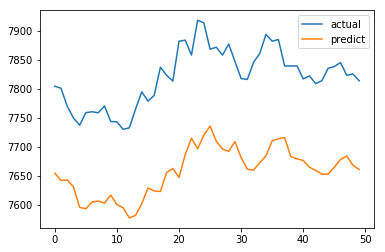

652 / 1373 = 0.4748725418790969


In [22]:
print(test_X.shape)
#print(range(test_X.shape))


pyplot.plot( inv_y, label='actual')
pyplot.plot( inv_yhat, label='predict')
pyplot.legend()
pyplot.show()

#涨跌的判准率

#获取预测跟实际对应元素值，是否大于0
a = np.diff(inv_y) > 0
b = np.diff(inv_yhat) > 0

#比较相同值的个数
print(sum(a == b), '/', a.shape[0], '=', sum(a == b)/a.shape[0])

## Multivariat with Multiple Lag Timesteps

In [39]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('bitcoin201901to201905.csv', header=0, index_col=0)
values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# specify the number of lag hours
n_hours = 64
# 等于 dataset.shape[1]
n_features = 5


# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

print(dataset.shape)
print(reframed.shape)


(13748, 5)
(13684, 325)


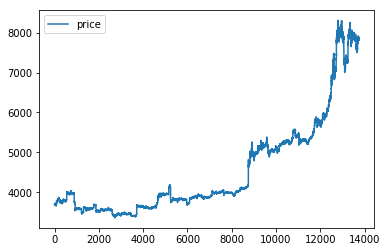

In [40]:
pyplot.plot(dataset['Close'].values, label='price')
pyplot.legend()
pyplot.show()

In [41]:

# split into train and test sets
values = reframed.values
n_train_rate = 0.9
n_train = values.shape[0] * n_train_rate
n_train = math.floor(n_train)
train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(12315, 320) 12315 (12315,)
(12315, 64, 5) (12315,) (1369, 64, 5) (1369,)


In [43]:
batch_size=15

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), stateful=True, batch_size=batch_size))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=25, batch_size=batch_size, 
                    #validation_data=(test_X, test_y), 
                     verbose=2, shuffle=False)

'''
import talos
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_grid = {
#    'clf__neurons_input':   [20, 25, 30, 35],
    'batch_size': [40,60,80], 
    'epochs': [10, 25, 50]
#    'clf__optimizer': ['Adam', 'Adadelta']
}

def create_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

model=KerasRegressor(build_fn=create_model, epochs=10, verbose=1)

p = {
    'epochs': [10, 25, 50],
    'batch_size': [16, 32, 50]
}

grid = GridSearchCV(estimator=model, param_grid=p, scoring='neg_mean_squared_error',
                               verbose=3,n_jobs=1)

    # fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)

grid.fit(train_X, train_y, validation_data=(test_X, test_y), verbose=2, shuffle=False)
'''

Epoch 1/25
 - 16s - loss: 0.0063
Epoch 2/25
 - 12s - loss: 0.0051
Epoch 3/25
 - 11s - loss: 0.0046
Epoch 4/25
 - 12s - loss: 0.0038
Epoch 5/25
 - 12s - loss: 0.0030
Epoch 6/25
 - 11s - loss: 0.0024
Epoch 7/25
 - 12s - loss: 0.0023
Epoch 8/25
 - 12s - loss: 0.0022
Epoch 9/25
 - 12s - loss: 0.0020
Epoch 10/25
 - 12s - loss: 0.0019
Epoch 11/25
 - 12s - loss: 0.0019
Epoch 12/25
 - 13s - loss: 0.0019
Epoch 13/25
 - 14s - loss: 0.0018
Epoch 14/25
 - 12s - loss: 0.0016
Epoch 15/25
 - 11s - loss: 0.0016
Epoch 16/25
 - 11s - loss: 0.0016
Epoch 17/25
 - 12s - loss: 0.0016
Epoch 18/25
 - 12s - loss: 0.0016
Epoch 19/25
 - 12s - loss: 0.0017
Epoch 20/25
 - 12s - loss: 0.0016
Epoch 21/25
 - 12s - loss: 0.0016
Epoch 22/25
 - 15s - loss: 0.0016
Epoch 23/25
 - 13s - loss: 0.0015
Epoch 24/25
 - 13s - loss: 0.0016
Epoch 25/25
 - 12s - loss: 0.0016


"\nimport talos\nfrom keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor\nfrom sklearn.model_selection import RandomizedSearchCV, GridSearchCV\n\nparam_grid = {\n#    'clf__neurons_input':   [20, 25, 30, 35],\n    'batch_size': [40,60,80], \n    'epochs': [10, 25, 50]\n#    'clf__optimizer': ['Adam', 'Adadelta']\n}\n\ndef create_model():\n    model = Sequential()\n    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))\n    model.add(Dense(1))\n    model.compile(loss='mae', optimizer='adam')\n    return model\n\nmodel=KerasRegressor(build_fn=create_model, epochs=10, verbose=1)\n\np = {\n    'epochs': [10, 25, 50],\n    'batch_size': [16, 32, 50]\n}\n\ngrid = GridSearchCV(estimator=model, param_grid=p, scoring='neg_mean_squared_error',\n                               verbose=3,n_jobs=1)\n\n    # fit network\n#history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)\n\ngrid.fit(train_X, t

In [44]:
print(grid.best_params_)
print(grid.score)

{'batch_size': 16, 'epochs': 10}
<bound method BaseSearchCV.score of GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f09e56b1550>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epochs': [10, 25, 50], 'batch_size': [16, 32, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)>


In [45]:
'''
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
'''

"\n# plot history\npyplot.plot(history.history['loss'], label='train')\npyplot.plot(history.history['val_loss'], label='test')\npyplot.legend()\npyplot.show()\n"

In [47]:
#test_X = test_X[-1344:]
#test_y  =

# make a prediction
yhat = model.predict(test_X)
#yhat = grid.predict(test_X)
print(yhat.shape)
yhat = yhat.reshape(yhat.shape[0],1)

test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
# inverse_transform must have matrix with the same dimensions when fit_transform() is first called
# 7 -> scaler.data_range_.shape[0] - 1 ?
# for bitbank dataset
#inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
# for poloniex dataset
inv_yhat = concatenate((yhat, test_X[:, -4:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
# for bitbank dataset
#inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

InvalidArgumentError: Incompatible shapes: [32,50] vs. [15,50]
	 [[{{node lstm_36/while/add_3}}]]

(1369, 320)


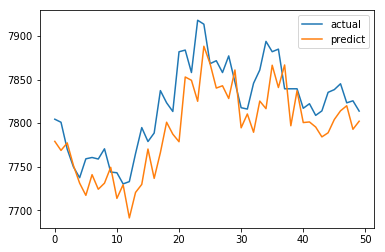

In [32]:
print(test_X.shape)
#print(range(test_X.shape))


pyplot.plot( inv_y[-50:], label='actual')
pyplot.plot( inv_yhat[-50:], label='predict')
pyplot.legend()
pyplot.show()

In [33]:
a = np.diff(inv_y) > 0
b = np.diff(inv_yhat) > 0

#比较相同值的个数
print(sum(a == b), '/', a.shape[0], '=', sum(a == b)/a.shape[0])

667 / 1368 = 0.48757309941520466


In [34]:
print(type(a))

<class 'numpy.ndarray'>
